<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 Pre-processing Pipeline and Data Augmentation

## 2.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import gaussian
from skimage.util import img_as_ubyte
import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the shared images folder (should be in shared/images)
images_dir = os.path.join(path, '..', 'shared', 'images')

# Set the directory to the data folder (should be in ML-LV/data/digits)
data_dir = os.path.join(path, 'data', 'digits')

# Create the directory if it doesn't exist
if not os.path.exists(os.path.join(data_dir, 'my_digits_mnist')):
    os.makedirs(os.path.join(data_dir, 'my_digits_mnist'))

## 2.1 Pre-processing pipeline

To build a pre-processing pipeline, first we will load a set of images of different dimensions.

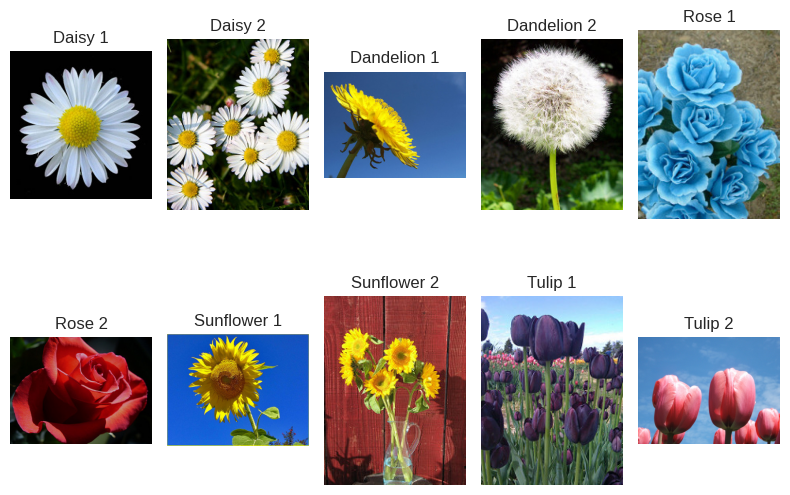

In [2]:
# Get the flower names
flower_names = os.listdir(os.path.join(images_dir, 'flowers'))
flower_names = [name.split('.')[0].replace('_', ' ').title() for name in flower_names]

# Load the flower images
flowers = io.imread_collection(os.path.join(images_dir, 'flowers', '*.jpg'))
flowers = np.asarray(flowers, dtype='object')  # Convert to numpy array

# Display the images
fig, ax = plt.subplots(2, 5, figsize=(8, 6))
ax = ax.ravel()
for i in range(len(flowers)):
    ax[i].imshow(flowers[i])
    ax[i].set_title(flower_names[i])
    ax[i].axis('off')
fig.tight_layout()
plt.show()

Now we can create a simple pre-processing pipeline by wrapping layers in a Keras sequential model. These can then be used inside another Keras model, like a layer, which processes the data during model execution. This can take advantage of GPU acceleration if you have it. Alternatively they can be used with a Tensorflow dataset or custom data generator.

This pipeline:

1. Resizes all images to 256x256.

2. Normalises the pixel values to the range [0, 1]. The reason for normalising pixel values is the same as numerical data: ANN work better with small, real numbers because large numbers have a disproportionate effect on the weights.

3. Applies some smoothing. There is no particular reason for this, it is only to demonstrate that we can wrap functions in Keras Lambda layers.

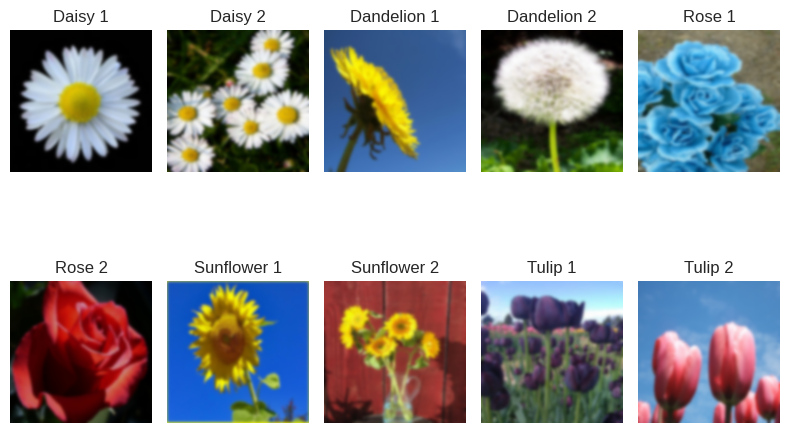

In [3]:
# Define the pre-processing layers
processing_pipeline = tf.keras.Sequential([
    layers.Resizing(256, 256), # Resize the images to 256x256
    layers.Rescaling(1./255), # Normalise pixel values to the [0, 1] range
    layers.Lambda(lambda x: gaussian(x, sigma=2.5, channel_axis=2)) # Custom layer to smooth the image
])

# Display the images
fig, ax = plt.subplots(2, 5, figsize=(8, 6))
ax = ax.ravel()
for i in range(len(flowers)):
    img = processing_pipeline(flowers[i])
    ax[i].imshow(img)
    ax[i].set_title(flower_names[i])
    ax[i].axis('off')
fig.tight_layout()
plt.show()

<div class="alert alert-info" style="color:black"><h2>2.2 Exercise: Digits pipeline</h2>

Now lets build a pipeline to process the images of digits created previously. The MNIST images are 28x28 binary pixels, so to use as a test set we need to convert our images into the same format. However, MNIST images also have a small boarder of pixels around each digit. So, first we need to resize each digit to 20x20 pixels and then add 4 pixels of padding to each border. It can also be helpful to add some smoothing so we don't end up with 'rough edges', 0.5 seems to work well but feel free to experiment.

1. In the following cell complete the `process_mnist()` function. It should take in the following arguments and return a Keras Sequential model `processing_pipeline` and an array of the processed digit images (`images`):
    - `images` is the input images to process.
    - `size` is the **final target size** of the output images, *including* padding, i.e. equal height and width of `size`.
    - `padding` is the border padding to apply to the images.
    - `interpol` is the interpolation method to use.
    - `smooth` is the standard deviation of the Gaussian filter for smoothing.

2. Create a pipeline that applies the following **in this order**:
    - Adds a 'dummy' channel dimension to the images (because Keras layers expect 3 dimensions and your images only have 2). You can use `tf.expand_dims` for this.
    - Resizes the images to the given size.
    - Converts the images into unsigned 8-bit integers. You can use `tf.cast()` for this.
    - Applies a small amount of smoothing.
    - Normalizes the pixels to the range [0, 255].
    - Adds padding to each side. You can use `tf.image.pad_to_bounding_box()` for this.
    - Removes the 'dummy' channel dimension. You can use `tf.squeeze()` for this.

3. Process each of the input digit images and returns them in an array.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

<div class="alert alert-success" style="color:black"><b>Note:</b> For all of these steps, except for resizing, you will need to use the Keras Lambda layer, which allows you to wrap a function into a layer.<br>

<code>layers.Lambda(lambda x: my_function(x))</code>
</div>

In [4]:
def process_mnist(images, size=28, padding=4, interpol='bilinear', smooth=0.5):
    """Converts a list of digit images to MNIST-like images.
    
    Arguments:
        images (np.ndarray): The images to process
        size (int): The final target size of the output images
        padding (int): The border padding to apply to the images
        interpol (str): The interpolation method to use
        smooth (float): The standard deviation of the Gaussian filter for smoothing
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    # Define the processing pipeline
    digit_pipeline = tf.keras.Sequential([
        # step 1 - add a dummy channel dimension
        layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),

        # step 2 - resize the images 20 x 20, the interpolation parameter in layers.
        layers.Resizing(20, 20, interpolation=interpol),

        # step 3 - normalises the pixels to the range [0, 1]
        layers.Lambda(lambda x: tf.cast(x, tf.float32) / 255.0),

        # step 4 - apply custom layer to smooth the image smoothing
        layers.Lambda(lambda x: gaussian(x, sigma=smooth)),

        # step 5 - scale back to [0, 255]
        layers.Rescaling(255),

        # step 6 - adds padding to the input image to resize it to the desired size and convert to unsigned 8-bit integers
        layers.Lambda(lambda x: tf.image.pad_to_bounding_box(tf.cast(x, tf.uint8), padding, padding, size, size)),  

        # step 7 - remove the dummy channel dimension
        layers.Lambda(lambda x: tf.squeeze(x, axis=-1))
        
    ])
    
    # Process each of the input digit images
    processed_images  = [digit_pipeline(image) for image in images]
    
    # convert to numpy array
    images = np.asarray(processed_images)
    
    # Check the dtype of the processed images before assertion
    #print("Processed images dtype:", images.dtype)

    # test the pipeline
    #print(len(digit_pipeline.layers))
    
    return digit_pipeline, images

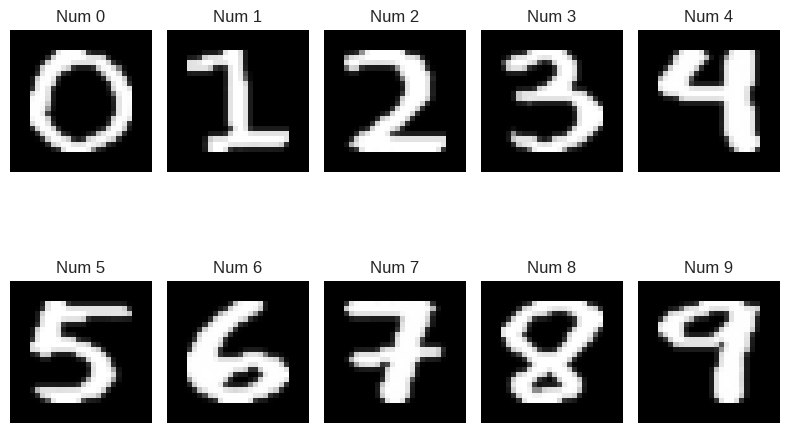

In [5]:
# Load the digit images
digits = io.imread_collection(os.path.join(data_dir, 'my_digits', '*.jpg'))
digits = np.asarray(digits, dtype='object')  # Convert to numpy array

# Process the images
pipeline, digits = process_mnist(digits, size=28, padding=4, interpol='bilinear', smooth=0.5)

# Display the images
fig, ax = plt.subplots(2, 5, figsize=(8, 6))
ax = ax.ravel()
for i in range(len(digits)):
    ax[i].imshow(digits[i], cmap='gray')
    ax[i].set_title("Num {}".format(i))
    ax[i].axis('off')
fig.tight_layout()
plt.show()

In [6]:
# Test cell (2 marks)

# Load the digit images
raw_digits = io.imread_collection(os.path.join(data_dir, 'my_digits', '*.jpg'))
raw_digits = np.asarray(raw_digits, dtype='object')  # Convert to numpy array

# Process the images
_, digits = process_mnist(raw_digits, size=28, padding=4, interpol='bilinear', smooth=0.5)

# Test the digits array is numpy
assert isinstance(digits, np.ndarray), "The digits array is not a numpy array"

# Test the images are the correct data type
assert digits.dtype == 'uint8', "The images are not the correct data type"

# Test the images are the correct size
assert digits.shape == (10, 28, 28), "The images are not the correct size"

# Test the images are in the correct range
assert np.max(digits[0]) <= 255 and np.min(digits[0]) == 0, "The images are not in the correct range"

# Test the padding is correct
assert np.sum(digits[0][:4, :]) == 0 and np.sum(digits[0][-4:, :]) == 0, "The row padding is not correct"
assert np.sum(digits[0][:, :4]) == 0 and np.sum(digits[0][:, -4:]) == 0, "The column padding is not correct"

print('All tests passed!')

All tests passed!


In [7]:
# Test cell (2 marks)

# Load the digit images
raw_digits = io.imread_collection(os.path.join(data_dir, 'my_digits', '*.jpg'))
raw_digits = np.asarray(raw_digits, dtype='object')  # Convert to numpy array

# Process the images
pipeline, _ = process_mnist(raw_digits, size=28, padding=4, interpol='bilinear', smooth=0.5)

# Test the pipeline is a Keras Sequential model
assert isinstance(pipeline, tf.keras.Sequential), "The pipeline is not a Keras Sequential model"

# Test the pipeline has the correct number of layers
assert len(pipeline.layers) == 7, "The pipeline does not have the correct number of layers"

# Test the pipeline has the correct layers
assert isinstance(pipeline.layers[0], layers.Lambda), "The pipeline does not start with a Lambda layer. Should be a Lambda layer with the function 'tf.expand_dims()'"
assert isinstance(pipeline.layers[1], layers.Resizing) and pipeline.layers[1].interpolation == 'bilinear', "The pipeline does not have a Resizing layer with the correct interpolation method"
assert isinstance(pipeline.layers[2], layers.Lambda), "The pipeline does not have a Lambda layer with the function 'tf.cast()'"
assert isinstance(pipeline.layers[3], layers.Lambda), "The pipeline does not have a Lambda layer with the function 'gaussian()'"
assert isinstance(pipeline.layers[4], layers.Rescaling), "The pipeline does not have a Rescaling layer"
assert isinstance(pipeline.layers[5], layers.Lambda), "The pipeline does not have a Lambda layer with the function 'tf.image.pad_to_bounding_box()'"
assert isinstance(pipeline.layers[6], layers.Lambda), "The pipeline does not have a Lambda layer with the function 'tf.squeeze()'"

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (1 mark)
# Tests with different argument options (size, padding, interpol, smooth)


### 2.2.1 Save the digits

Once you have completed your function, save each of the images as separate files in a folder called `my_digits_mnist`, and name them e.g. `digit_1.jpg`, etc. You should have 10 images that look something like this:

![mnist digits](../../../shared/images/mnist_digits.png)

<div class="alert alert-success" style="color:black"><b>Note:</b> We need to convert the images back to an unsigned 8 bit integer before saving using the function <code>img_as_ubyte()</code>.
</div>

In [336]:
if not grading:
    # Load the digit images
    digits = io.imread_collection(os.path.join(data_dir, 'my_digits', '*.jpg'))
    digits = np.asarray(digits, dtype='object')  # Convert to numpy array

    # Process the images
    _, digits = process_mnist(digits, size=28, padding=4, interpol='bilinear', smooth=0.5)

    # Save the processed digits
    for i, digit in enumerate(digits):
        io.imsave(os.path.join(data_dir, 'my_digits_mnist', 'digit_{}.jpg'.format(i)), img_as_ubyte(digit))

## 2.3 Data Augmentation

We can build a data augmentation pipeline using the same technique. Keras has a number of built-in augmentation layers. It is not always desirable to apply augmentation to *all* images, so many of the Keras layers only apply a transformation with some random probability.

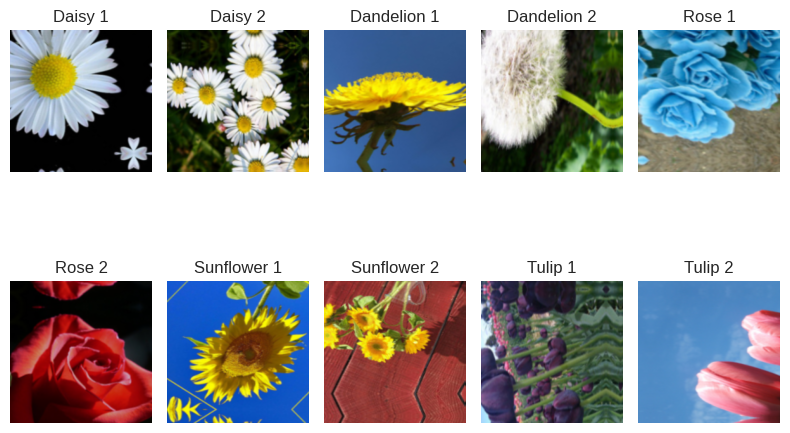

In [371]:
# Define the pre-processing layers
processing_pipeline = tf.keras.Sequential([
    layers.Resizing(256, 256), # Resize the images to 256x256
    layers.Rescaling(1./255), # Normalise pixel values to the [0, 1] range
])

# Define the augmentation layers
augmentaion_pipeline = tf.keras.Sequential([
    layers.RandomFlip(), # Randomly flip the images horizontally or vertically
    layers.RandomRotation(factor=(-0.25, 0.25)), # Randomly rotate the images between -90 and 90 degrees
    layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), # Randomly translate the images
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), # Randomly zoom the images
    layers.RandomCrop(224, 224) # Randomly crop the images to 224x224
])

# Display the images
fig, ax = plt.subplots(2, 5, figsize=(8, 6))
ax = ax.ravel()
for i in range(len(flowers)):
    img = processing_pipeline(flowers[i])
    img = augmentaion_pipeline(img)
    ax[i].imshow(img)
    ax[i].set_title(flower_names[i])
    ax[i].axis('off')
fig.tight_layout()
plt.show() 


# # Define the data augmentation pipeline
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip('horizontal_and_vertical'), 
#     layers.RandomRotation(0.2), 
#     layers.RandomZoom(0.2), 
# ])

# # Apply the data augmentation pipeline
# augmented_digits = data_augmentation(digits)

# # Display the augmented digits
# fig, ax = plt.subplots(2, 5, figsize=(10, 6))
# ax = ax.ravel()
# for i, img in enumerate(augmented_digits):
#     ax[i].imshow(img, cmap='gray')
#     ax[i].set_title("Augmented Digit {}".format(i))
#     ax[i].axis('off')
# fig.tight_layout()
# plt.show()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280
